# 4. Predictive Analytics
## b) Deep Learning
Repeat the steps from subtask 4a), but this time use a feedforward neural network.
- Is the performance very different from the previous approach?
- With this realization, do you think it is worth to employ a deep-learning approach?

In [ ]:
# Imports
import vaex
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
def plot_true_vs_prediction(y_pred,y_test):

    y_pred = y_pred.flatten()
    # create sorted series for true and predicted values
    y_pred_series = pd.Series(np.array(y_pred) ,index = y_test.index)
    y_pred_series_sorted = y_pred_series.sort_index()
    y_test_sorted = y_test.sort_index()

    # plot true vs predicted values
    fig,ax = plt.subplots(figsize = (20, 10), dpi = 80)
    ax.plot(y_test_sorted, label = "true", linewidth = 2, color = "tab:gray")
    ax.plot(y_pred_series_sorted, label = "prediction", linewidth = 1, alpha = 0.6, color = "tab:blue")
    ax.set_ylabel('Total System-Level Demand')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()

    # evaluation metrics
    print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
    print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))

In [ ]:
def plot_history(history):

    train_loss = history.history['loss']
    train_mae = history.history['mae']
    train_r2 = history.history['r_squared']
    val_loss = history.history['val_loss']
    val_mae = history.history['val_mae']
    val_r2 = history.history['val_r_squared']

    # Create an array of epochs
    #epochs = range(1, len(train_loss) + 1)
    epochs = np.arange(0, len(train_loss))

    # Plot training loss vs. validation loss
    plt.figure(figsize=(7, 3))
    plt.plot(epochs-1, train_loss, 'b-', label='Training Loss (MSE)')
    #plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training mean squared error vs. validation mae
    plt.figure(figsize=(7, 3))
    plt.plot(epochs-1, train_mae, 'b-', label='Training MAE')
    #plt.plot(epochs, train_mae, 'b-', label='Training MAE')
    plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    # Plot training r squared  vs. validation r squared
    plt.figure(figsize=(7, 3))
    plt.plot(epochs-1, train_r2, 'b-', label='Training R^2')
    #plt.plot(epochs, train_r2, 'b-', label='Training R^2')
    plt.plot(epochs, val_r2, 'r-', label='Validation R^2')
    plt.title('Training and Validation R^2')
    plt.xlabel('Epochs')
    plt.ylabel('R^2')
    plt.legend()
    plt.show()

In [ ]:
def r_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = 1.0 - (residual / total)
    return r2


In [46]:
def getDFs(timeB, resolution):
  hdf = vaex.open("data/trips/trips_grouped_" + str(timeB) + "h_r" + str(resolution) + ".hdf")
  df = hdf.to_pandas_df()
  # Independent variables columns
  iVars = ["start_month", "start_weekday", "start_"+str(timeB)+"_hour", "pickup_hex_"+str(resolution)]
  # All interesting columns
  iColumns = ["demand"] + iVars
  # Select interesting columns
  sdf = df[iColumns]
  sdf = sdf.groupby(iVars).mean().reset_index()
  sdf = sdf[(sdf["pickup_hex_"+str(resolution)].notna()) & (sdf["pickup_hex_"+str(resolution)] != "None")]
  # Devide into X andf y
  data = sdf
  X = data[iVars]
  y = data["demand"]
  # Convert Hexagon into Dummies
  X = pd.get_dummies(X, columns = ["pickup_hex_"+str(resolution)])
  # Convert into float for Keras
  X = X.astype("float32")
  y = y.astype("float")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)
  return X_train, X_test, X_val, y_train, y_test, y_val

In [92]:
def getDFs_withWeather(timeB, resolution):
  hdf = vaex.open("data/trips/trips_grouped_" + str(timeB) + "h_r" + str(resolution) + ".hdf")
  df = hdf.to_pandas_df()
  # Independent variables columns
  iVars = ["start_month", "start_weekday", "start_"+str(timeB)+"_hour", "pickup_hex_"+str(resolution)]
  # All interesting columns
  iColumns = ["demand"] + iVars
  # Select interesting columns
  sdf = df[iColumns + ["ts_start_1_hour"]]
  # weather
  weather_attributes = ['Temperature', 'Humidity', 'Precip.', 'cloud']
  weather_df = pd.read_pickle("data/weather.pickle")
  weather_df = weather_df[weather_attributes]
  sdf = sdf.merge(weather_df, left_on='ts_start_1_hour', right_on='datetime', how='left')
  sdf = sdf.groupby(iVars + weather_attributes).mean().reset_index()
  sdf = sdf[(sdf["pickup_hex_"+str(resolution)].notna()) & (sdf["pickup_hex_"+str(resolution)] != "None")]
  # Devide into X andf y
  data = sdf
  X = data[iVars + weather_attributes]
  y = data["demand"]
  # Convert Hexagon into Dummies
  X = pd.get_dummies(X, columns = ["pickup_hex_"+str(resolution)])
  # Convert into float for Keras
  X = X.astype("float32")
  y = y.astype("float")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)
  return X_train, X_test, X_val, y_train, y_test, y_val

## Performance Comparison
First we repeat the steps from 4a) and compare the performance

### Example 1h time, resolution 5

In [106]:
# First Example from the last notebook: 1h time, resolution 5
# Get Data
timeB = 1
resolution = 5
X_train, X_test, X_val, y_train, y_test, y_val = getDFs_withWeather(timeB, resolution)

#Build Model
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

#Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=35, batch_size=64)


Epoch 1/35


<ipython-input-92-e222188819a7>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sdf = sdf.groupby(iVars + weather_attributes).mean().reset_index()


558/558 [==============================] - 2s 2ms/step - loss: 1300632.6250 - mae: 670.1978 - r_squared: -0.0284 - val_loss: 1171669.6250 - val_mae: 706.4470 - val_r_squared: 0.0622
Epoch 2/35
558/558 [==============================] - 1s 2ms/step - loss: 527917.3750 - mae: 382.7934 - r_squared: 0.5598 - val_loss: 314897.9688 - val_mae: 278.4675 - val_r_squared: 0.7325
Epoch 3/35
558/558 [==============================] - 1s 2ms/step - loss: 269426.7500 - mae: 246.1529 - r_squared: 0.7799 - val_loss: 277766.0000 - val_mae: 247.2549 - val_r_squared: 0.7698
Epoch 4/35
558/558 [==============================] - 1s 2ms/step - loss: 263263.4375 - mae: 241.3045 - r_squared: 0.7854 - val_loss: 274095.3438 - val_mae: 250.9418 - val_r_squared: 0.7738
Epoch 5/35
558/558 [==============================] - 1s 2ms/step - loss: 253277.2188 - mae: 234.0691 - r_squared: 0.7873 - val_loss: 265602.0938 - val_mae: 241.4634 - val_r_squared: 0.7802
Epoch 6/35
558/558 [==============================] - 1s 2

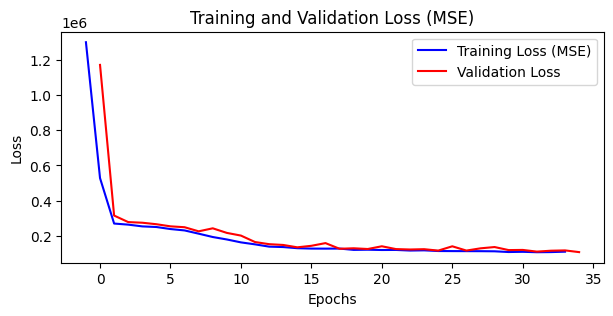

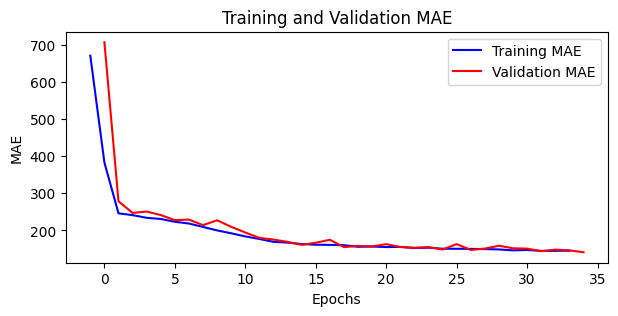

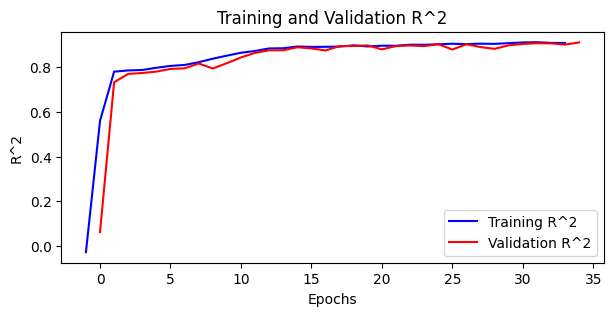

In [109]:
plot_history(history)

In [110]:
# Step 6: Evaluate the model on the test set
test_loss, test_mae, test_r2 = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Mean Absolute Error:", test_mae)
print("Test R^2:", test_r2)

349/349 [==============================] - 0s 993us/step - loss: 99168.9062 - mae: 139.2264 - r_squared: 0.8900
Test Loss: 99168.90625
Test Mean Absolute Error: 139.22637939453125
Test R^2: 0.8900399804115295


We can compare this to the results of the SVR and see, that the Neural Network performed better:
- Mean Squared Error: 343266.20633396995
- Mean Absolute Error: 254.99522480296753
- R-squared: 0.7007637490151778

In [112]:
#!!!

# Also hier würde ich jetzt eigentlich die weiteren Beispiele aus der SVR nehmen und ebenfalls mit dem Neural Network vergleichen. Bisher konnte ich jedoch keine weiteren finden.

# @Tobi mach doch das SVR Notebook sehr nah an der Aufgabenstellung:
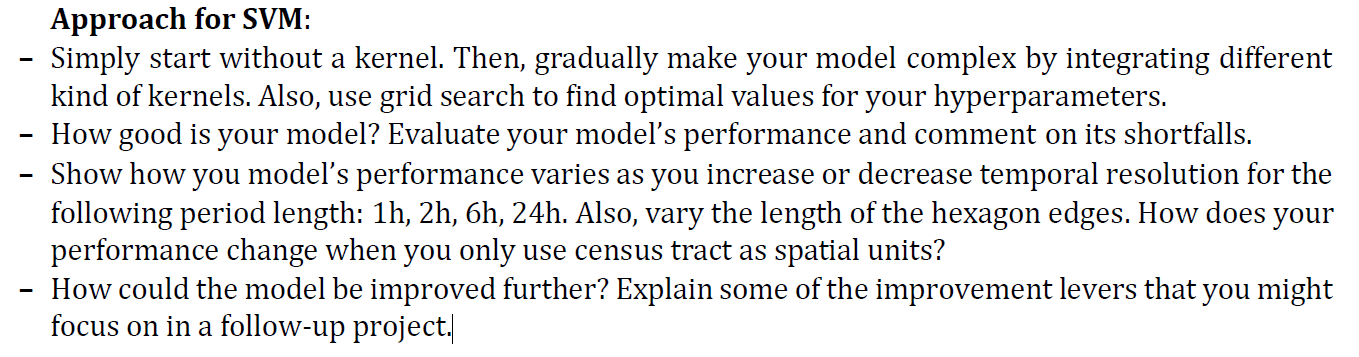
# und dann kannst du die gleichen Inputs einmal hier durch ein NN jagen und vergleichen. Wie das geht kannst du ja oben sehen.

In [113]:
# !!!

## Possibility of higher resolution
As discussed in 4a, with SVR it is complicated to use a high resolution as every Hexagon results in a variable and there are limited varibales possible.
With Neural Networks we don't have this problem. Have a look:

### Resolution of 7

In [40]:
# Get Data
timeB = 1
resolution = 7
X_train, X_test, X_val, y_train, y_test, y_val = getDFs(timeB, resolution)

#Build Model
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

#Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)


Epoch 1/50
1340/1340 [==============================] - 4s 2ms/step - loss: 16810.2598 - mae: 40.1459 - r_squared: 0.4122 - val_loss: 6260.1108 - val_mae: 23.1540 - val_r_squared: 0.7715
Epoch 2/50
1340/1340 [==============================] - 3s 2ms/step - loss: 5700.0537 - mae: 22.6125 - r_squared: 0.7498 - val_loss: 3964.7200 - val_mae: 18.5185 - val_r_squared: 0.7916
Epoch 3/50
1340/1340 [==============================] - 4s 3ms/step - loss: 4411.5254 - mae: 18.7281 - r_squared: 0.8059 - val_loss: 3199.3647 - val_mae: 16.4796 - val_r_squared: 0.8709
Epoch 4/50
1340/1340 [==============================] - 3s 2ms/step - loss: 3424.5850 - mae: 16.3836 - r_squared: 0.8624 - val_loss: 2275.3496 - val_mae: 13.8833 - val_r_squared: 0.9190
Epoch 5/50
1340/1340 [==============================] - 3s 2ms/step - loss: 3120.5662 - mae: 15.2629 - r_squared: 0.8770 - val_loss: 2639.1399 - val_mae: 14.6530 - val_r_squared: 0.9093
Epoch 6/50
1340/1340 [==============================] - 3s 2ms/step -

838/838 [==============================] - 1s 1ms/step


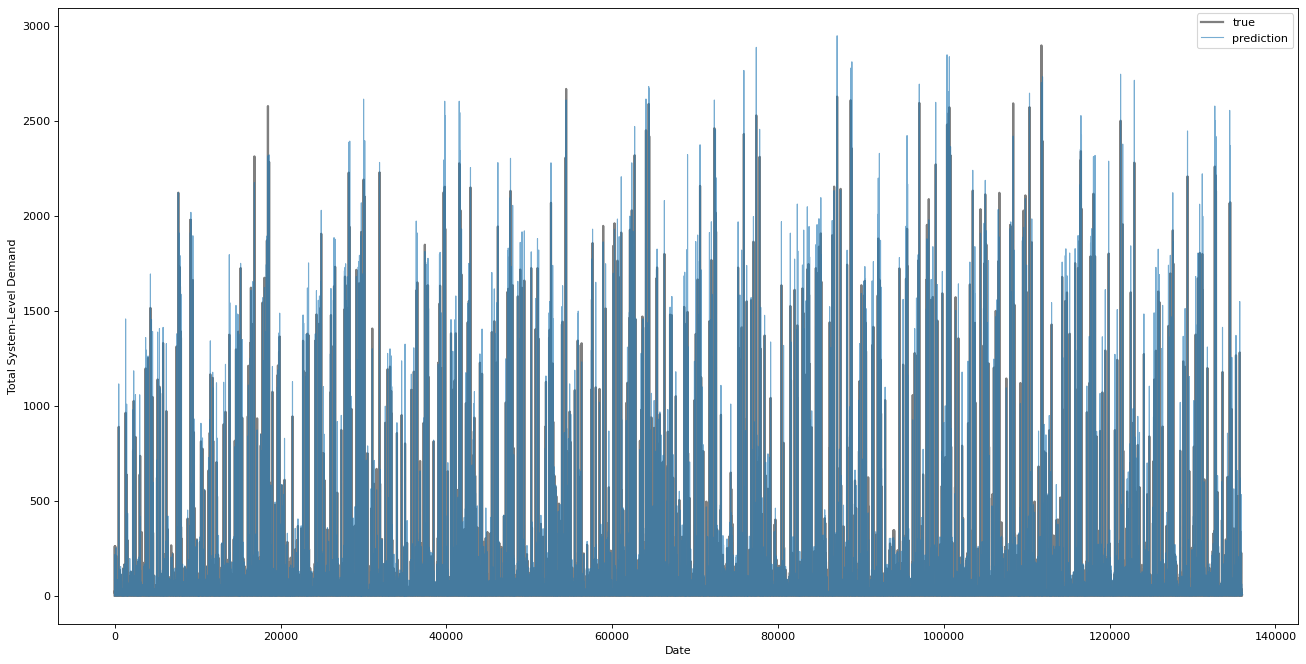

Mean Squared Error: 1613.3131455867097
Mean Absolute Error: 9.488667422549424


In [44]:
plot_true_vs_prediction(model.predict(X_test),y_test)

In [43]:
# Step 6: Evaluate the model on the test set
test_loss, test_mae, test_r2 = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Mean Absolute Error:", test_mae)
print("Test R^2:", test_r2)

838/838 [==============================] - 2s 2ms/step - loss: 1613.3140 - mae: 9.4887 - r_squared: 0.9294
Test Loss: 1613.31396484375
Test Mean Absolute Error: 9.488661766052246
Test R^2: 0.9293750524520874


### Resolution of 8

In [50]:
# Get Data
timeB = 1
resolution = 8
X_train, X_test, X_val, y_train, y_test, y_val = getDFs(timeB, resolution)

#Build Model
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
opt = RMSprop(learning_rate=0.005)
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

#Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)


Epoch 1/20
2766/2766 [==============================] - 22s 8ms/step - loss: 1600.5315 - mae: 13.8808 - r_squared: 0.6671 - val_loss: 713.2602 - val_mae: 8.5535 - val_r_squared: 0.8299
Epoch 2/20
2766/2766 [==============================] - 22s 8ms/step - loss: 781.1834 - mae: 9.1864 - r_squared: 0.8404 - val_loss: 548.3547 - val_mae: 7.8208 - val_r_squared: 0.8899
Epoch 3/20
2766/2766 [==============================] - 20s 7ms/step - loss: 624.5984 - mae: 8.0775 - r_squared: 0.8746 - val_loss: 717.0674 - val_mae: 10.2122 - val_r_squared: 0.8129
Epoch 4/20
2766/2766 [==============================] - 22s 8ms/step - loss: 551.2583 - mae: 7.5976 - r_squared: 0.8883 - val_loss: 615.6606 - val_mae: 7.6894 - val_r_squared: 0.9065
Epoch 5/20
2766/2766 [==============================] - 25s 9ms/step - loss: 486.4910 - mae: 7.1974 - r_squared: 0.9005 - val_loss: 345.6216 - val_mae: 6.2721 - val_r_squared: 0.9286
Epoch 6/20
2766/2766 [==============================] - 21s 8ms/step - loss: 400.2

1729/1729 [==============================] - 3s 2ms/step


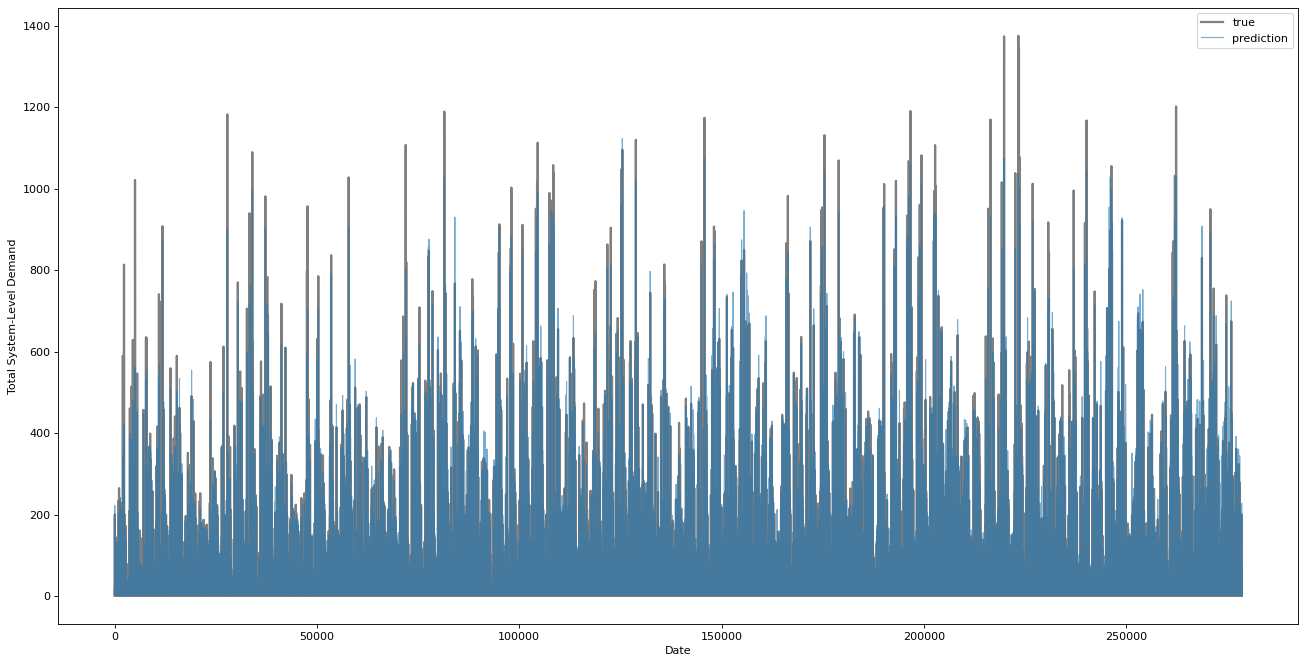

Mean Squared Error: 160.8063942782641
Mean Absolute Error: 4.411988318315478


In [52]:
plot_true_vs_prediction(model.predict(X_test),y_test)

In [53]:
# Step 6: Evaluate the model on the test set
test_loss, test_mae, test_r2 = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Mean Absolute Error:", test_mae)
print("Test R^2:", test_r2)

1729/1729 [==============================] - 3s 2ms/step - loss: 160.8064 - mae: 4.4120 - r_squared: 0.9511
Test Loss: 160.8064422607422
Test Mean Absolute Error: 4.411990165710449
Test R^2: 0.9510644674301147


In [127]:
len(X_train.columns)

474

As Neural Networks are very flexible with their input parameter size, it is no problem to look hat higher resolutions. In this case we had 474 columns.

## Conclusion

Support Vector Regression works by finding the best hyperplane to separate data. This can be effective for some data types and is particularly useful when working with small datasets.

However, when working with many variables because of higher spatial resolution, NNs have an advantage. They are well-suited for handling large datasets and complex problems. Also the NNs have outperformed SVR in terms of MSE, MAE, and R2 metrics.

But it's important to note that NNs can require significant computational resources, particularly when working with large datasets. Additionally, the performance of a NN can be greatly affected by its architecture (e.g., the number of layers and neurons), and choosing the right architecture can be challenging.